# Big Data Project - DE3 - 2021
_Julian MOTYL, Quentin THIZY, et Kent BRUDEY_

**Création d'un script d'apprentissage automatique de classification supervisée déterminant à partir d'un extrait de CV, le métier du titulaire parmis 28 catégories de métiers.**

`Entrées` :


*   _categories_string.csv_ => **job, id_job**
*   _categories_label.csv_ => **id_cv, id_job**
*   _data.json_ => **id_cv, cv, gender**


`Sorties` :


*   _data.csv_ => **id_cv, cv, gender**
*   _predict.csv_ => **id_cv, prediction : (id_job(s), y, y_pred, score, score_m, score_f, bow : \[ {word(s), weight(s)} \] )**
*   _predict.json_ => **id_cv, prediction : (id_job(s), y, y_pred,, score, score_m, score_f, bow : \[ {word(s), weight(s)} \] )**

`Notes` : 
*   Chaque notebook est autonome et peut être exécuté indépendamment. 
*   Penser à lire la partie **`XX. Prérequis`** pour vous assurer que tous les paramètres soient corrects.

## `3.` Entraînement des modèles d'apprentissage automatique

### `30.` Prérequis
#### `30.a.` Emplacement du dossier

 **Renseigner la variable `path` correspondant à l'emplacement du dossier `CV Extract Classifier`.**

In [1]:
# /!\ A modifier selon le chemin sur votre OS des fichiers de données /!\
########################################################

#from google.colab import drive
#drive.mount("/content/drive")
#path = "/content/drive/My Drive/Colab Notebooks/"

path = "/home/syn/Documents/Formations/Data science/BigData/" + "CV Extract Classifier/"

########################################################

#### `30.b.` Librairies

In [2]:
# Pandas pour les dataframes
import pandas as pd

# Math et Numpy pour les calculs mathématiques
import math
import numpy as np

# Seaborn et Matplotlib pour les plots
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors
%matplotlib inline

# Datetime pour obtenir la date et l'heure (nombre unique lors de l'export de fichiers pour éviter les écrasements)
import datetime as dt

# Pickle afin d'enregistrer nos résultats et les rendre exploitable sur plusieurs notebooks
import pickle

# NLTK
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *

# Gensim
import gensim
from gensim import corpora, models
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS


# SciKit-Learn
from sklearn import svm
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import CategoricalNB, MultinomialNB
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV, ShuffleSplit
from sklearn.linear_model import LogisticRegression

# PPRINT pour afficher esthétiquement des infos sur les modèles utilisés
from pprint import pprint

[nltk_data] Downloading package wordnet to /home/syn/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /home/syn/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/syn/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


#### `30.c.` Fonctions

In [3]:
def show_most_informative_features_nonlinear(vectorizer, clf, n=20):
    feature_names = vectorizer.get_feature_names()
    for i, class_ in enumerate(clf.classes_) :
      print ("{} {}".format(class_,df_job.job.iloc[i]))
      coefs_with_fns = sorted(zip(clf.dual_coef_[i], feature_names))
      top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
      for (coef_1, fn_1), (coef_2, fn_2) in top:
          print("\t%.4f\t%-15s\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))

def show_most_informative_features(vectorizer, clf, n=20):
    feature_names = vectorizer.get_feature_names()
    for i, class_ in enumerate(clf.classes_) :
      print ("{} {}".format(class_,df_job.job.iloc[i]))
      coefs_with_fns = sorted(zip(clf.coef_[i], feature_names))
      top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
      for (coef_1, fn_1), (coef_2, fn_2) in top:
          print("\t%.4f\t%-15s\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))

def important_features(vectorizer,classifier,n=20):
    class_labels = classifier.classes_
    feature_names =vectorizer.get_feature_names()
    i = 0
    for class_ in class_labels :
      topn_class = sorted(zip(classifier.coef_[i], feature_names),reverse=True)[:n]

      print("Important words in "+df_job.job[i]+" CV")

      for coef, feat in topn_class:
          print(class_, coef, feat)

      print("-----------------------------------------")
      i+=1

def print_top(vectorizer, clf, n, coef = False):
    """Prints features with the highest coefficient values, per class"""
    class_labels = clf.classes_
    feature_names = vectorizer.get_feature_names()
    for i, class_label in enumerate(class_labels):
        #print(clf.coef_[i])
        topn = np.argsort(clf.coef_[i])[-n:]
        if (coef) :
          for j in topn :
            print("(%s) %.4f : %s" % (df_job.job[class_label], clf.coef_[i][j], feature_names[j]))
        else :
          print("%s: %s" % (class_label,
                " | ".join(feature_names[j] for j in topn)))

def model_score_dataframe(label_test, label_train, feature_test, feature_train, set_name, df_gender_info, vect=TfidfVectorizer(), vect_name='TF-IDF', model=LogisticRegression(), clf_name='Naive Bayes', preproc='CLEN, STEM, LEMM, LOWC, STPW'):
  d = {
     'Classifier': clf_name,
     'Training Set F1-Score': f1_score(label_train, model.predict(feature_train), average="macro"),
     'Test Set F1-Score': f1_score(label_test, model.predict(feature_test), average="macro"),
     'Job Proportion Max Gap': (label_train.value_counts().max()/label_train.value_counts().sum()) - (label_train.value_counts().min()/label_train.value_counts().sum()),
     'Female/Male Ratio': df_gender_info[df_gender_info.Set == set_name]["Female/Male Ratio"],
     'Female/Male per Job Max Gap': df_gender_info[df_gender_info.Set == set_name]["Female/Male per Job Max Gap"],
     'Vectorizer': vect_name,
     'Training Set Shape' : str(feature_train.shape),
     'Test Set Shape' : str(feature_test.shape),
     'Vectorizer Params': str(vect.get_params()),
     'Preprocess': preproc,
     'Classifier Params': str(model.get_params())
  }
  return pd.DataFrame(d, index=[0])

def show_conf_matrix(feature_test, label_test, model, set_name, clf_name, df_gender_info, df_job):
  aux_df = df_job[['job', 'id_job']].drop_duplicates().sort_values('id_job')
  conf_matrix = confusion_matrix(label_test, model.predict(feature_test))
  plt.figure(figsize=(25.6,12))
  sns.heatmap(conf_matrix, 
              annot=True,
              xticklabels=aux_df['job'].values, 
              yticklabels=aux_df['job'].values,
              cmap="Blues",
              fmt='g')
  plt.ylabel('Predicted')
  plt.xlabel('Actual')
  # Ideal Set-score must be 1 (lower or higher is lesser)
  plt.title('Confusion matrix - {} - F1-score : {}% - Set-score : {}'.format(clf_name, f1_score(label_test, model.predict(feature_test), average="macro")*100, df_gender_info[df_gender_info.Set == set_name]["Set-score"][0]))

  plt.show()

### `31.F.` Test des modèles de classification - _`Naive Bayes`_

#### `31.F.a.` Import des pickles en dataframes

In [4]:
# TF-IDF vectorizer
path_tfidf = '{}3. Model Training/Pickles/tfidf.pickle'.format(path)
with open(path_tfidf, 'rb') as data:
    tfidf = pickle.load(data)

# Dataframe de toutes les catégories de métiers
path_df = '{}3. Model Training/Pickles/df_job.pickle'.format(path)
with open(path_df, 'rb') as data:
    df_job = pickle.load(data)

In [5]:
# TF-IDF features of X_eq_parity_train
path_ft = '{}3. Model Training/Pickles/features_ep_train.pickle'.format(path)
with open(path_ft, 'rb') as data:
    ft_ep_train = pickle.load(data)

# TF-IDF features of X_eq_parity_test
path_ft = '{}3. Model Training/Pickles/features_ep_test.pickle'.format(path)
with open(path_ft, 'rb') as data:
    ft_ep_test = pickle.load(data)

# labels from y_eq_parity_train
path_ft = '{}3. Model Training/Pickles/labels_ep_train.pickle'.format(path)
with open(path_ft, 'rb') as data:
    lb_ep_train = pickle.load(data)

# labels from y_eq_parity_test
path_ft = '{}3. Model Training/Pickles/labels_ep_test.pickle'.format(path)
with open(path_ft, 'rb') as data:
    lb_ep_test = pickle.load(data)

In [6]:
# TF-IDF features of X_eq_train
path_ft = '{}3. Model Training/Pickles/features_e_train.pickle'.format(path)
with open(path_ft, 'rb') as data:
    ft_e_train = pickle.load(data)

# TF-IDF features of X_eq_test
path_ft = '{}3. Model Training/Pickles/features_e_test.pickle'.format(path)
with open(path_ft, 'rb') as data:
    ft_e_test = pickle.load(data)

# labels from y_eq_train
path_ft = '{}3. Model Training/Pickles/labels_e_train.pickle'.format(path)
with open(path_ft, 'rb') as data:
    lb_e_train = pickle.load(data)

# labels from y_eq_test
path_ft = '{}3. Model Training/Pickles/labels_e_test.pickle'.format(path)
with open(path_ft, 'rb') as data:
    lb_e_test = pickle.load(data)

In [7]:
# TF-IDF features of X_parity_train
path_ft = '{}3. Model Training/Pickles/features_p_train.pickle'.format(path)
with open(path_ft, 'rb') as data:
    ft_p_train = pickle.load(data)

# TF-IDF features of X_parity_test
path_ft = '{}3. Model Training/Pickles/features_p_test.pickle'.format(path)
with open(path_ft, 'rb') as data:
    ft_p_test = pickle.load(data)

# labels from y_parity_train
path_ft = '{}3. Model Training/Pickles/labels_p_train.pickle'.format(path)
with open(path_ft, 'rb') as data:
    lb_p_train = pickle.load(data)

# labels from y_parity_test
path_ft = '{}3. Model Training/Pickles/labels_p_test.pickle'.format(path)
with open(path_ft, 'rb') as data:
    lb_p_test = pickle.load(data)

In [8]:
# TF-IDF features of X_min_parity_train
path_ft = '{}3. Model Training/Pickles/features_mp_train.pickle'.format(path)
with open(path_ft, 'rb') as data:
    ft_mp_train = pickle.load(data)

# TF-IDF features of X_min_parity_test
path_ft = '{}3. Model Training/Pickles/features_mp_test.pickle'.format(path)
with open(path_ft, 'rb') as data:
    ft_mp_test = pickle.load(data)

# labels from y_min_parity_train
path_ft = '{}3. Model Training/Pickles/labels_mp_train.pickle'.format(path)
with open(path_ft, 'rb') as data:
    lb_mp_train = pickle.load(data)

# labels from y_min_parity_test
path_ft = '{}3. Model Training/Pickles/labels_mp_test.pickle'.format(path)
with open(path_ft, 'rb') as data:
    lb_mp_test = pickle.load(data)

In [9]:
# TF-IDF features of X_train
path_ft = '{}3. Model Training/Pickles/features_train.pickle'.format(path)
with open(path_ft, 'rb') as data:
    ft_train = pickle.load(data)

# TF-IDF features of X_test
path_ft = '{}3. Model Training/Pickles/features_test.pickle'.format(path)
with open(path_ft, 'rb') as data:
    ft_test = pickle.load(data)

# labels from y_train
path_ft = '{}3. Model Training/Pickles/labels_train.pickle'.format(path)
with open(path_ft, 'rb') as data:
    lb_train = pickle.load(data)

# labels from y_test
path_ft = '{}3. Model Training/Pickles/labels_test.pickle'.format(path)
with open(path_ft, 'rb') as data:
    lb_test = pickle.load(data)

In [10]:
# Dataframe info genre - df_info_genre
path_df = '{}3. Model Training/Pickles/df_info_genre.pickle'.format(path)
with open(path_df, 'rb') as data:
    df_info_genre = pickle.load(data)

In [11]:
# Dataframe scores - df_scores
path_df = '{}3. Model Training/Pickles/df_scores.pickle'.format(path)
with open(path_df, 'rb') as data:
    df_scores = pickle.load(data)

In [12]:
#print(ft_ep_train[0])
#print(ft_ep_test[0])
print('\nParameters currently in use in TF-IDF:\n')
pprint(tfidf.get_params())


Parameters currently in use in TF-IDF:

{'analyzer': 'word',
 'binary': False,
 'decode_error': 'strict',
 'dtype': <class 'numpy.float64'>,
 'encoding': 'utf-8',
 'input': 'content',
 'lowercase': True,
 'max_df': 1.0,
 'max_features': None,
 'min_df': 1,
 'ngram_range': (1, 1),
 'norm': 'l2',
 'preprocessor': None,
 'smooth_idf': True,
 'stop_words': None,
 'strip_accents': None,
 'sublinear_tf': False,
 'token_pattern': '(?u)\\b\\w\\w+\\b',
 'tokenizer': None,
 'use_idf': True,
 'vocabulary': None}


In [13]:
# Création d'un dataframe permettant de comparer les scores
df_scores = pd.DataFrame()

#### `31.F.b.` Naive Bayes

In [13]:
nb_model = MultinomialNB()
print('Parameters currently in use in NB:\n')
pprint(nb_model.get_params())

Parameters currently in use in NB:

{'alpha': 1.0, 'class_prior': None, 'fit_prior': True}


##### `31.F.b.1` Dataframe équilibré et paritaire

In [14]:
nb_model.fit(ft_ep_train,lb_ep_train)

# Training f1-score
print("The training f1-score is: ")
print(f1_score(lb_ep_train, nb_model.predict(ft_ep_train), average="macro"))

nb_model_pred = nb_model.predict(ft_ep_test)

# Test f1-score
print("The test f1-score is: ")
print(f1_score(lb_ep_test, nb_model_pred, average="macro"))

The training f1-score is: 
0.9701814059708856
The test f1-score is: 
0.687198688729073


In [15]:
show_most_informative_features(tfidf, nb_model, 30)

0 pastor
	-9.4737	a__jeffhammond 		-7.2572	agnik          
	-9.4737	a_lentino      		-7.6660	automorph      
	-9.4737	aa             		-7.8579	ashworth       
	-9.4737	aaa            		-8.2105	barcella       
	-9.4737	aaaaj          		-8.2113	agep           
	-9.4737	aaaasf         		-8.2301	andi           
	-9.4737	aaacd          		-8.2824	bareback       
	-9.4737	aaai           		-8.3003	ainu           
	-9.4737	aaaj           		-8.3485	agjuran        
	-9.4737	aaal           		-8.3495	bhoomanaa      
	-9.4737	aaalac         		-8.3913	bhausaheb      
	-9.4737	aaar           		-8.3934	aimb           
	-9.4737	aaari          		-8.4170	ahram          
	-9.4737	aaasf          		-8.4231	anticoncept    
	-9.4737	aaasp          		-8.4304	bhailal        
	-9.4737	aab            		-8.4487	bibm           
	-9.4737	aabb           		-8.4660	accumark       
	-9.4737	aabet          		-8.4687	aden           
	-9.4737	aabha          		-8.5284	bianco         
	-9.4737	aabhar         		-8.5454	battery

In [16]:
df_score_model = model_score_dataframe(lb_ep_test, lb_ep_train, ft_ep_test, ft_ep_train, "EQP", df_info_genre, tfidf,'TF-IDF', nb_model,'Naive Bayes')
df_scores = pd.concat([df_scores,df_score_model])

In [17]:
df_score_model

Classifier  Training Set F1-Score  Test Set F1-Score  \
0  Naive Bayes               0.970181           0.687199   

   Job Proportion Max Gap  Female/Male Ratio  Female/Male per Job Max Gap  \
0                0.000418                1.0                          0.0   

  Vectorizer Training Set Shape Test Set Shape  \
0     TF-IDF      (2391, 12607)  (1025, 12607)   

                                   Vectorizer Params  \
0  {'analyzer': 'word', 'binary': False, 'decode_...   

                     Preprocess  \
0  CLEN, STEM, LEMM, LOWC, STPW   

                                   Classifier Params  
0  {'alpha': 1.0, 'class_prior': None, 'fit_prior...


###### Rapport de classification

In [18]:
print(classification_report(lb_ep_test,nb_model_pred))

              precision    recall  f1-score   support

           0       0.62      0.78      0.69        37
           1       0.71      0.32      0.44        37
           2       0.79      0.89      0.84        37
           3       0.65      0.35      0.46        37
           4       0.81      0.81      0.81        36
           5       0.75      0.83      0.79        36
           6       0.54      0.57      0.55        37
           7       0.80      0.89      0.84        36
           8       0.69      0.68      0.68        37
           9       0.67      0.70      0.68        37
          10       0.69      0.65      0.67        37
          11       0.42      0.50      0.46        36
          12       0.73      0.83      0.78        36
          13       0.85      0.64      0.73        36
          14       0.80      0.43      0.56        37
          15       0.68      0.83      0.75        36
          16       0.91      0.78      0.84        37
          17       0.80    

###### Matrice de confusion

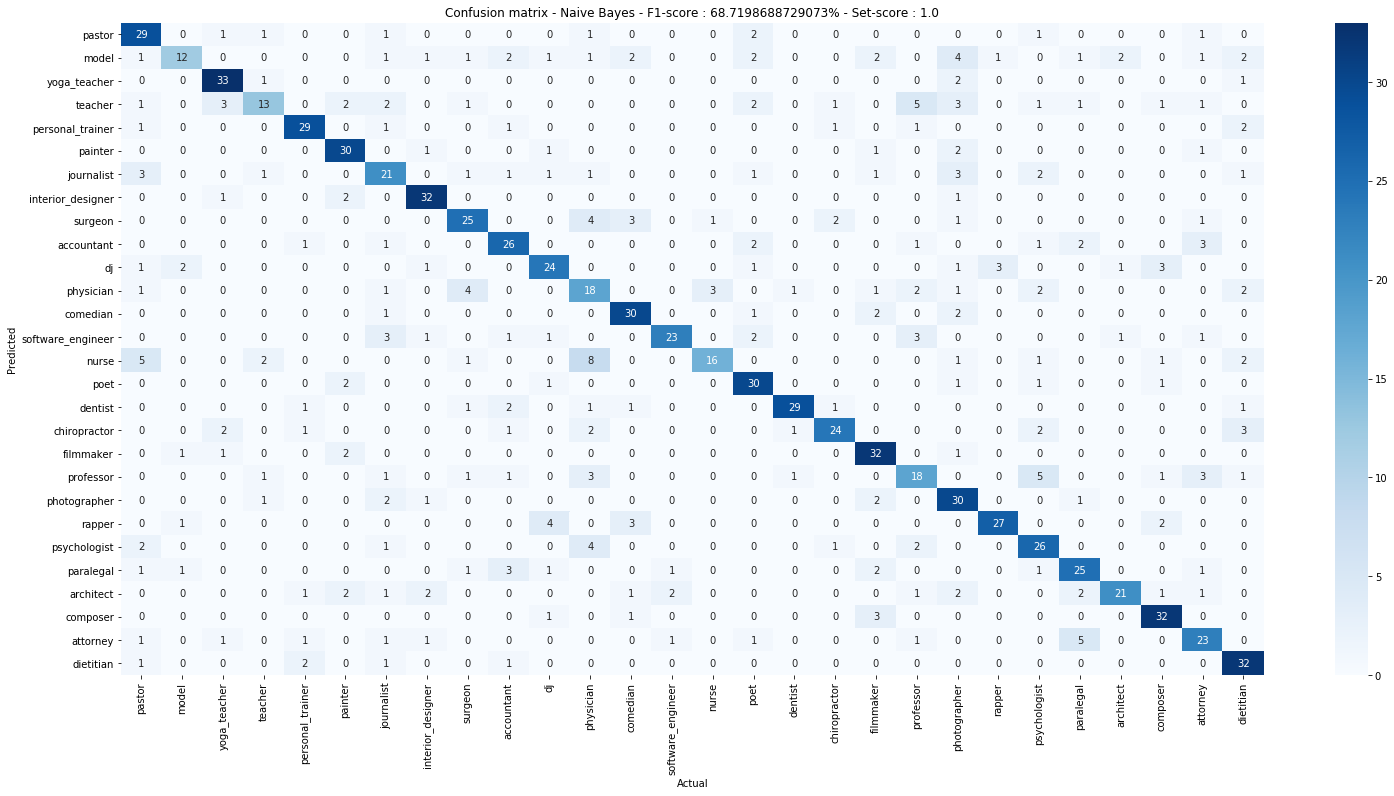

In [19]:
show_conf_matrix(ft_ep_test, lb_ep_test, nb_model, "EQP", 'Naive Bayes', df_info_genre, df_job)

##### `31.F.b.2` Dataframe équilibré en proportion de catégories de métiers

In [20]:
nb_model.fit(ft_e_train,lb_e_train)

nb_model_pred = nb_model.predict(ft_e_test)

# Training f1-score))

plt.show()
print("The training f1-score is: ")
print(f1_score(lb_e_train, nb_model.predict(ft_e_train), average="macro"))

# Test f1-score
print("The test f1-score is: ")
print(f1_score(lb_e_test, nb_model_pred, average="macro"))

show_most_informative_features(tfidf, nb_model, 10)

The training f1-score is: 
0.8763871385210479
The test f1-score is: 
0.7216442519863351
0 pastor
	-10.5814	a__jeffhammond 		-7.0279	aqsa           
	-10.5814	a_lentino      		-7.3516	complaint      
	-10.5814	aa             		-7.4358	checkmark      
	-10.5814	aaa            		-7.4771	dorai          
	-10.5814	aaaaj          		-7.7639	decondit       
	-10.5814	aaaasf         		-7.8234	deepteastudio  
	-10.5814	aaacd          		-7.8426	bioartifici    
	-10.5814	aaai           		-7.8548	apsia          
	-10.5814	aaaj           		-8.0981	appercept      
	-10.5814	aaal           		-8.1435	aljumuah       
1 model
	-10.5831	a__jeffhammond 		-6.7929	chesne         
	-10.5831	a_lentino      		-7.9262	adulter        
	-10.5831	aaa            		-8.0041	becenti        
	-10.5831	aaaaj          		-8.0520	caver          
	-10.5831	aaaasf         		-8.2825	asert          
	-10.5831	aaacd          		-8.3452	albuern        
	-10.5831	aaai           		-8.3944	bildbyran      
	-10.5831	aaaj           		-

In [21]:
df_score_model = model_score_dataframe(lb_e_test, lb_e_train, ft_e_test, ft_e_train, "EQI", df_info_genre, tfidf,'TF-IDF', nb_model,'Naive Bayes')
df_scores = pd.concat([df_scores,df_score_model])

In [22]:
df_score_model

Classifier  Training Set F1-Score  Test Set F1-Score  \
0  Naive Bayes               0.876387           0.721644   

   Job Proportion Max Gap  Female/Male Ratio  Female/Male per Job Max Gap  \
0                0.000065           0.738344                     0.844189   

  Vectorizer Training Set Shape Test Set Shape  \
0     TF-IDF     (15346, 36878)  (6578, 36878)   

                                   Vectorizer Params  \
0  {'analyzer': 'word', 'binary': False, 'decode_...   

                     Preprocess  \
0  CLEN, STEM, LEMM, LOWC, STPW   

                                   Classifier Params  
0  {'alpha': 1.0, 'class_prior': None, 'fit_prior...

###### Rapport de classification

In [23]:
print(classification_report(lb_e_test,nb_model_pred))

              precision    recall  f1-score   support

           0       0.72      0.82      0.77       235
           1       0.81      0.58      0.68       235
           2       0.75      0.90      0.82       235
           3       0.64      0.37      0.46       235
           4       0.71      0.86      0.78       234
           5       0.77      0.87      0.81       235
           6       0.59      0.64      0.61       235
           7       0.73      0.84      0.78       235
           8       0.81      0.75      0.78       235
           9       0.72      0.76      0.74       235
          10       0.75      0.80      0.78       235
          11       0.60      0.56      0.58       235
          12       0.69      0.78      0.73       235
          13       0.64      0.81      0.71       234
          14       0.81      0.65      0.72       235
          15       0.72      0.72      0.72       235
          16       0.87      0.80      0.83       235
          17       0.93    

###### Matrice de confusion

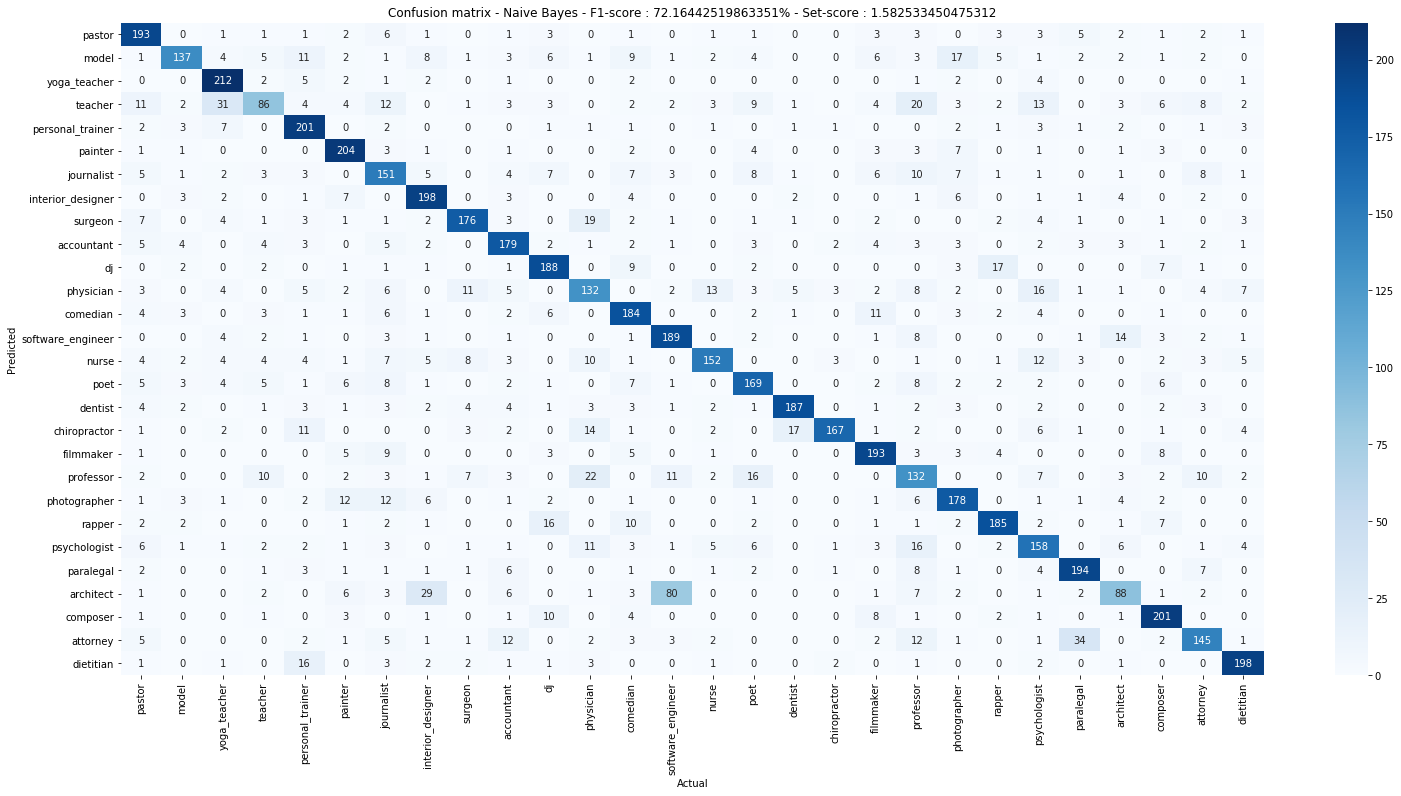

In [24]:
show_conf_matrix(ft_e_test, lb_e_test, nb_model, "EQI", 'Naive Bayes', df_info_genre, df_job)

##### `31.F.b.3` Dataframe paritaire

In [33]:
nb_model.fit(ft_p_train,lb_p_train)

nb_model_pred = nb_model.predict(ft_p_test)

# Training f1-score
print("The training f1-score is: ")
print(f1_score(lb_p_train, nb_model.predict(ft_p_train), average="macro"))

# Test f1-score
print("The test f1-score is: ")
print(f1_score(lb_p_test, nb_model_pred, average="macro"))

show_most_informative_features(tfidf, nb_model, 10)

The training f1-score is: 
0.14198290294450955
The test f1-score is: 
0.1277113816608274
0 pastor
	-11.6469	a__jeffhammond 		-8.0488	candl          
	-11.6469	a_lentino      		-8.2947	matricul       
	-11.6469	aa             		-8.5829	kitchenwar     
	-11.6469	aaa            		-8.6964	raban          
	-11.6469	aaaaj          		-8.7851	oriana         
	-11.6469	aaaasf         		-8.9141	evamaefarm     
	-11.6469	aaacd          		-9.0069	osler          
	-11.6469	aaai           		-9.1499	shereff        
	-11.6469	aaaj           		-9.1625	camlinh        
	-11.6469	aaal           		-9.2110	ipap           
1 model
	-11.6670	a__jeffhammond 		-7.5179	kolbasina      
	-11.6670	a_lentino      		-8.6248	dormanc        
	-11.6670	aa             		-8.7065	anglim         
	-11.6670	aaa            		-8.8525	jbvamc         
	-11.6670	aaaaj          		-8.8569	shereff        
	-11.6670	aaaasf         		-8.9363	babylon        
	-11.6670	aaacd          		-8.9557	sesmad         
	-11.6670	aaai           		

In [34]:
df_score_model = model_score_dataframe(lb_p_test, lb_p_train, ft_p_test, ft_p_train, "PAR", df_info_genre, tfidf,'TF-IDF', nb_model,'Naive Bayes')
df_scores = pd.concat([df_scores,df_score_model])

In [35]:
df_score_model

Classifier  Training Set F1-Score  Test Set F1-Score  \
0  Naive Bayes               0.141983           0.127711   

   Job Proportion Max Gap  Female/Male Ratio  Female/Male per Job Max Gap  \
0                0.400809                1.0                          0.0   

  Vectorizer Training Set Shape   Test Set Shape  \
0     TF-IDF   (109536, 112034)  (46944, 112034)   

                                   Vectorizer Params  \
0  {'analyzer': 'word', 'binary': False, 'decode_...   

                     Preprocess  \
0  CLEN, STEM, LEMM, LOWC, STPW   

                                   Classifier Params  
0  {'alpha': 1.0, 'class_prior': None, 'fit_prior...

###### Rapport de classification

In [36]:
print(classification_report(lb_p_test,nb_model_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       216
           1       0.00      0.00      0.00       430
           2       0.00      0.00      0.00        85
           3       0.73      0.00      0.01      2235
           4       0.00      0.00      0.00       218
           5       0.97      0.02      0.04      1279
           6       0.76      0.15      0.25      3674
           7       0.00      0.00      0.00        98
           8       1.00      0.00      0.00       534
           9       0.00      0.00      0.00       677
          10       0.00      0.00      0.00        75
          11       0.81      0.48      0.60      2749
          12       0.00      0.00      0.00       207
          13       0.00      0.00      0.00       368
          14       0.00      0.00      0.00       677
          15       0.82      0.01      0.01      1283
          16       0.98      0.42      0.59      1137
          17       0.00    

###### Matrice de confusion

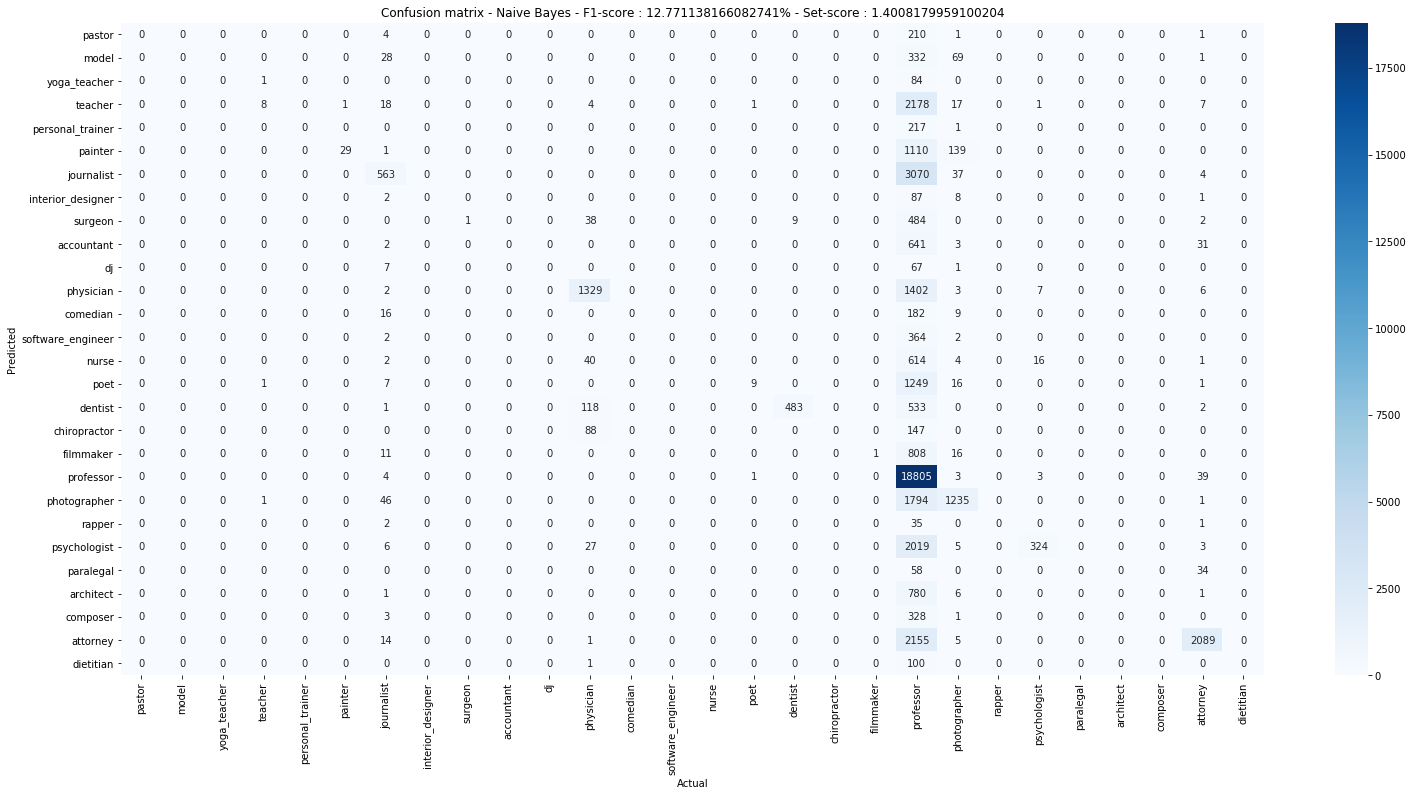

In [37]:
show_conf_matrix(ft_p_test, lb_p_test, nb_model, "PAR", 'Naive Bayes', df_info_genre, df_job)

##### `31.F.b.4` Dataframe paritaire et voulu équilibré en proportion de catégories de métiers

In [25]:
nb_model.fit(ft_mp_train,lb_mp_train)


nb_model_pred = nb_model.predict(ft_mp_test)

# Training f1-score
print("The training f1-score is: ")
print(f1_score(lb_mp_train, nb_model.predict(ft_mp_train), average="macro"))

# Test f1-score
print("The test f1-score is: ")
print(f1_score(lb_mp_test, nb_model_pred, average="macro"))

show_most_informative_features(tfidf, nb_model, 10)

The training f1-score is: 
0.5348989418964204
The test f1-score is: 
0.3752043686193126
0 pastor
	-10.1841	a__jeffhammond 		-7.1756	ameritrust     
	-10.1841	a_lentino      		-7.4540	buarqu         
	-10.1841	aa             		-7.6637	bolen          
	-10.1841	aaa            		-7.8642	cico           
	-10.1841	aaaaj          		-7.9589	americanboard  
	-10.1841	aaaasf         		-8.0328	ceeisa         
	-10.1841	aaacd          		-8.1374	cellar         
	-10.1841	aaai           		-8.2398	andragogi      
	-10.1841	aaaj           		-8.2779	condotalk      
	-10.1841	aaal           		-8.2789	açor           
1 model
	-10.1742	a__jeffhammond 		-7.5309	bonekey        
	-10.1742	a_lentino      		-8.4030	asunción       
	-10.1742	aa             		-8.4929	biven          
	-10.1742	aaa            		-8.5328	actra          
	-10.1742	aaaaj          		-8.7236	bushey         
	-10.1742	aaaasf         		-8.7661	biorefineri    
	-10.1742	aaacd          		-8.7779	concetu        
	-10.1742	aaai           		-

In [26]:
df_score_model = model_score_dataframe(lb_mp_test, lb_mp_train, ft_mp_test, ft_mp_train, "MIP", df_info_genre, tfidf,'TF-IDF', nb_model,'Naive Bayes')
df_scores = pd.concat([df_scores,df_score_model])

In [27]:
df_score_model

Classifier  Training Set F1-Score  Test Set F1-Score  \
0  Naive Bayes               0.534899           0.375204   

   Job Proportion Max Gap  Female/Male Ratio  Female/Male per Job Max Gap  \
0                0.053373                1.0                          0.0   

  Vectorizer Training Set Shape Test Set Shape  \
0     TF-IDF      (8094, 25172)  (3470, 25172)   

                                   Vectorizer Params  \
0  {'analyzer': 'word', 'binary': False, 'decode_...   

                     Preprocess  \
0  CLEN, STEM, LEMM, LOWC, STPW   

                                   Classifier Params  
0  {'alpha': 1.0, 'class_prior': None, 'fit_prior...

###### Rapport de classification

In [28]:
print(classification_report(lb_mp_test,nb_model_pred))

              precision    recall  f1-score   support

           0       0.94      0.37      0.53       119
           1       1.00      0.01      0.02        92
           2       0.88      0.09      0.17        74
           3       0.43      0.57      0.49       212
           4       0.52      0.93      0.67       212
           5       0.45      0.95      0.61       221
           6       0.38      0.79      0.52       214
           7       0.95      0.20      0.33        91
           8       0.80      0.06      0.12        63
           9       0.85      0.73      0.79       145
          10       1.00      0.03      0.06        68
          11       0.53      0.53      0.53       167
          12       0.93      0.29      0.44        91
          13       0.00      0.00      0.00        37
          14       0.00      0.00      0.00        36
          15       0.55      0.88      0.68       220
          16       0.95      0.60      0.73       131
          17       0.95    

###### Matrice de confusion

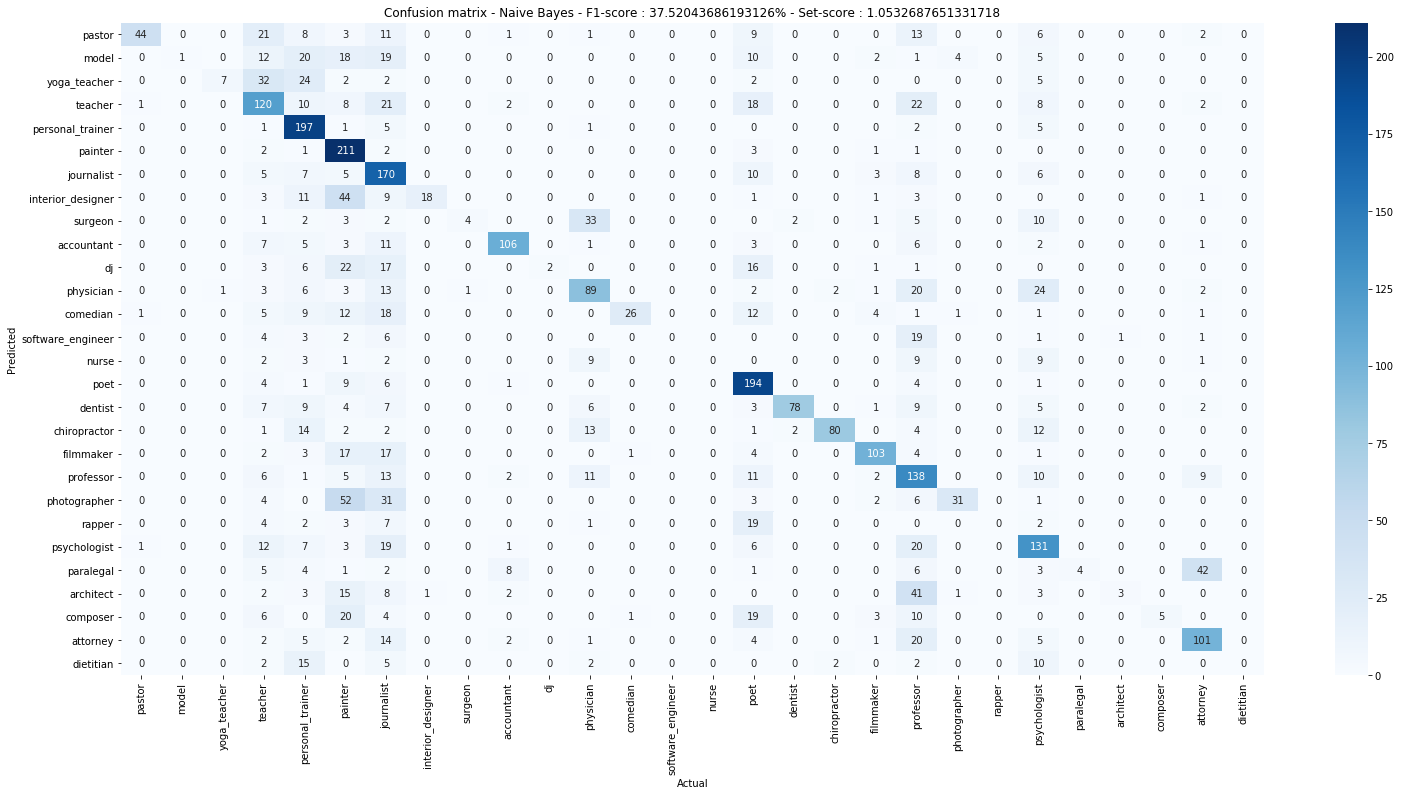

In [29]:
show_conf_matrix(ft_mp_test, lb_mp_test, nb_model, "MIP", 'Naive Bayes', df_info_genre, df_job)

##### `31.F.b.5` Dataframe brut

In [38]:
nb_model.fit(ft_train,lb_train)

nb_model_pred = nb_model.predict(ft_test)

# Training f1-score
print("The training f1-score is: ")
print(f1_score(lb_train, nb_model.predict(ft_train), average="macro"))

# Test f1-score
print("The test f1-score is: ")
print(f1_score(lb_test, nb_model_pred, average="macro"))

show_most_informative_features(tfidf, nb_model, 10)

The training f1-score is: 
0.18107752984952424
The test f1-score is: 
0.16578827239251487
0 pastor
	-11.8619	a__jeffhammond 		-7.5214	church         
	-11.8619	a_lentino      		-7.7982	pastor         
	-11.8619	aa             		-7.8987	ministri       
	-11.8619	aaa            		-8.1645	theolog        
	-11.8619	aaaaj          		-8.3241	seminari       
	-11.8619	aaaasf         		-8.3874	god            
	-11.8619	aaacd          		-8.5106	serv           
	-11.8619	aaai           		-8.5637	wife           
	-11.8619	aaaj           		-8.5791	christian      
	-11.8619	aaal           		-8.7606	christ         
1 model
	-11.9128	a__jeffhammond 		-5.9282	freeon         
	-11.9128	a_lentino      		-6.6154	current        
	-11.9128	aaa            		-6.6656	rank           
	-11.9128	aaaaj          		-6.7210	link           
	-11.9128	aaaasf         		-6.7216	bear           
	-11.9128	aaacd          		-6.7664	section        
	-11.9128	aaai           		-6.7887	th             
	-11.9128	aaaj           	

In [39]:
df_score_model = model_score_dataframe(lb_test, lb_train, ft_test, ft_train, "RAW", df_info_genre, tfidf,'TF-IDF', nb_model,'Naive Bayes')
df_scores = pd.concat([df_scores,df_score_model])

In [40]:
df_score_model

Classifier  Training Set F1-Score  Test Set F1-Score  \
0  Naive Bayes               0.181078           0.165788   

   Job Proportion Max Gap  Female/Male Ratio  Female/Male per Job Max Gap  \
0                0.318758           0.841386                     0.853147   

  Vectorizer Training Set Shape   Test Set Shape  \
0     TF-IDF   (152037, 137029)  (65160, 137029)   

                                   Vectorizer Params  \
0  {'analyzer': 'word', 'binary': False, 'decode_...   

                     Preprocess  \
0  CLEN, STEM, LEMM, LOWC, STPW   

                                   Classifier Params  
0  {'alpha': 1.0, 'class_prior': None, 'fit_prior...

###### Rapport de classification

In [41]:
print(classification_report(lb_test,nb_model_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       449
           1       0.99      0.26      0.41      1235
           2       0.00      0.00      0.00       283
           3       0.47      0.00      0.01      2744
           4       0.00      0.00      0.00       242
           5       0.95      0.02      0.03      1386
           6       0.80      0.09      0.16      3689
           7       0.00      0.00      0.00       257
           8       0.90      0.09      0.17      1985
           9       1.00      0.00      0.00       936
          10       0.00      0.00      0.00       249
          11       0.68      0.41      0.51      3482
          12       1.00      0.00      0.00       492
          13       0.86      0.01      0.03      1218
          14       0.76      0.59      0.66      3787
          15       0.75      0.00      0.00      1288
          16       0.96      0.51      0.67      1635
          17       0.00    

###### Matrice de confusion

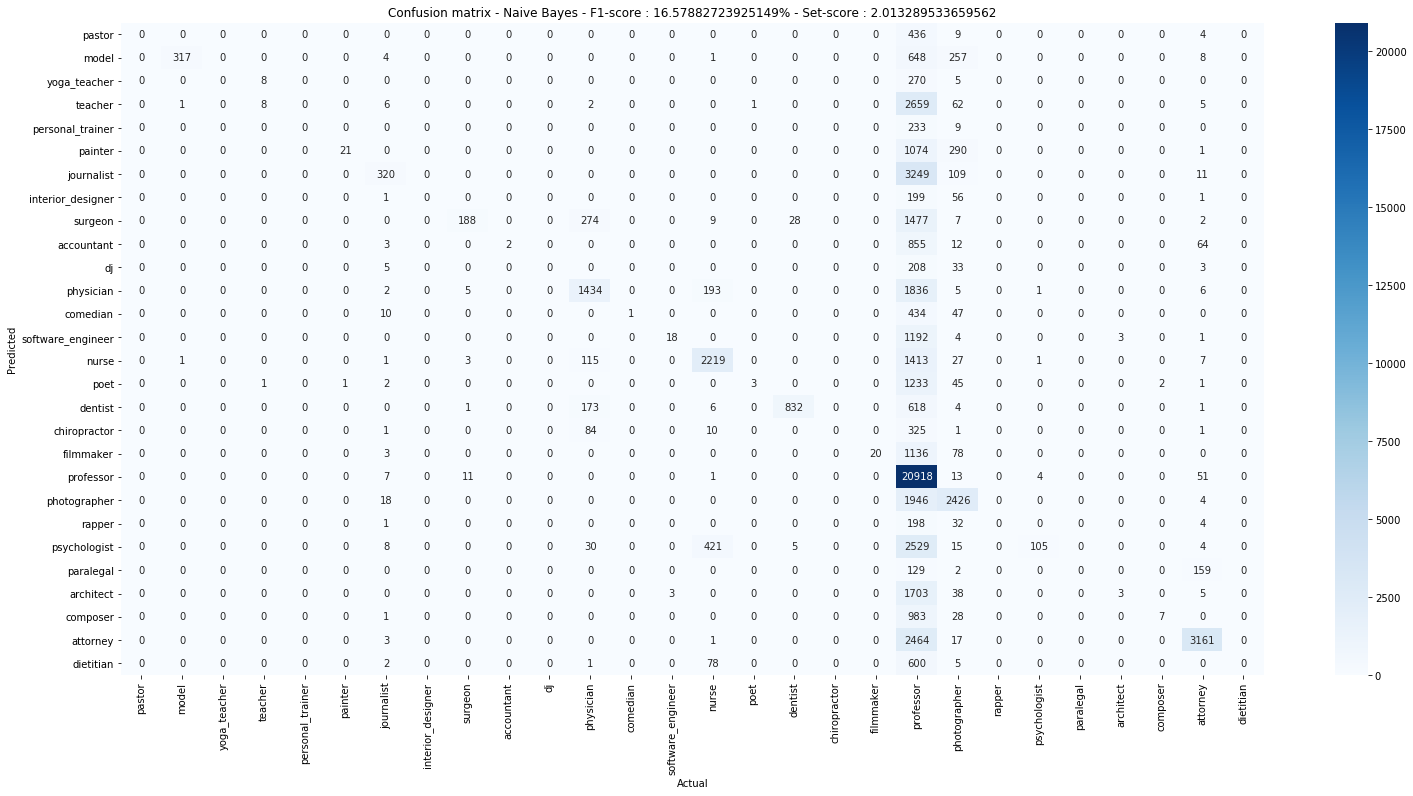

In [42]:
show_conf_matrix(ft_test, lb_test, nb_model, "RAW", 'Naive Bayes', df_info_genre, df_job)

### `32.F.` Comparaison des scores du classifieur - _`Naive Bayes`_

In [43]:
df_scores

Classifier  Training Set F1-Score  Test Set F1-Score  \
0   Logistic Regression               0.950876           0.693362   
1   Logistic Regression               0.882137           0.748109   
2   Logistic Regression               0.685629           0.612652   
3   Logistic Regression               0.851504           0.666419   
4   Logistic Regression               0.790678           0.728585   
5   K Nearest Neighbors               0.708248           0.566894   
6   K Nearest Neighbors               0.746222           0.617361   
7   K Nearest Neighbors               0.715828           0.574088   
8                   SVM               0.998329           0.689197   
9                   SVM               0.988892           0.741264   
10                  SVM               0.987651           0.638346   
0           Naive Bayes               0.970181           0.687199   
0           Naive Bayes               0.876387           0.721644   
0           Naive Bayes               0.534899           0.375204   
0           Naive Bayes               0.141983           0.127711   
0           Naive Bayes               0.181078           0.165788   

    Job Proportion Max Gap  Female/Male Ratio  Female/Male per Job Max Gap  \
0                 0.000418           1.000000                     0.000000   
1                 0.000065           0.738344                     0.844189   
2                 0.400809           1.000000                     0.000000   
3                 0.053373           1.000000                     0.000000   
4                 0.318758           0.841386                     0.853147   
5                 0.000418           1.000000                     0.000000   
6                 0.000065           0.738344                     0.844189   
7                 0.053373           1.000000                     0.000000   
8                 0.000418           1.000000                     0.000000   
9                 0.000065           0.738344                     0.844189   
10                0.053373           1.000000                     0.000000   
0                 0.000418           1.000000                     0.000000   
0                 0.000065           0.738344                     0.844189   
0                 0.053373           1.000000                     0.000000   
0                 0.400809           1.000000                     0.000000   
0                 0.318758           0.841386                     0.853147   

   Vectorizer Training Set Shape   Test Set Shape  \
0      TF-IDF      (2391, 12607)    (1025, 12607)   
1      TF-IDF     (15346, 36878)    (6578, 36878)   
2      TF-IDF   (109536, 112034)  (46944, 112034)   
3      TF-IDF      (8094, 25172)    (3470, 25172)   
4      TF-IDF   (152037, 137029)  (65160, 137029)   
5      TF-IDF      (2391, 12607)    (1025, 12607)   
6      TF-IDF     (15346, 36878)    (6578, 36878)   
7      TF-IDF      (8094, 25172)    (3470, 25172)   
8      TF-IDF      (2391, 12607)    (1025, 12607)   
9      TF-IDF     (15346, 36878)    (6578, 36878)   
10     TF-IDF      (8094, 25172)    (3470, 25172)   
0      TF-IDF      (2391, 12607)    (1025, 12607)   
0      TF-IDF     (15346, 36878)    (6578, 36878)   
0      TF-IDF      (8094, 25172)    (3470, 25172)   
0      TF-IDF   (109536, 112034)  (46944, 112034)   
0      TF-IDF   (152037, 137029)  (65160, 137029)   

                                    Vectorizer Params  \
0   {'analyzer': 'word', 'binary': False, 'decode_...   
1   {'analyzer': 'word', 'binary': False, 'decode_...   
2   {'analyzer': 'word', 'binary': False, 'decode_...   
3   {'analyzer': 'word', 'binary': False, 'decode_...   
4   {'analyzer': 'word', 'binary': False, 'decode_...   
5   {'analyzer': 'word', 'binary': False, 'decode_...   
6   {'analyzer': 'word', 'binary': False, 'decode_...   
7   {'analyzer': 'word', 'binary': False, 'decode_...   
8   {'analyzer': 'word', 'binary': False, 'decode_...   
9   {'analyzer': 'word', 'binary': False

Nous retiendrons donc le set `EQI` avec un _f1-score_ de **72%**.

### `33.F.` Export des dataframes en pickles
On va pouvoir passer au notebook suivant en y important nos dataframes nouvellement formés.

In [44]:
now = dt.datetime.now()
datm = "{}{}{}{}{}{}".format(now.year,now.month,now.day,now.hour,now.minute,now.second)

In [10]:
# Naive Bayes - nb_model
with open(f'{path}3. Model Training/Pickles/{datm}.nb_model.pickle', 'wb') as output:
    pickle.dump(nb_model, output)

In [45]:
# Dataframe des scores - df_scores
with open(f'{path}3. Model Training/Pickles/{datm}.df_scores.pickle', 'wb') as output:
    pickle.dump(df_scores, output)

### `34.F.` Sources
* [TfidfVectorizer SciKit Learn](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html#sklearn.feature_extraction.text.TfidfVectorizer.get_params)